changes: try binary encoding

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.dates as mdates
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.preprocessing import QuantileTransformer, PowerTransformer

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
meals = pd.read_csv('meal_info.csv')
centres = pd.read_csv('fulfilment_center_info.csv')

# Exploratory Data Analysis: EDA
# Dataset overview

In [ ]:
test.head(1)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0


In [ ]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [ ]:
train.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


# Data Preparation and Processing

## Univariate Analysis

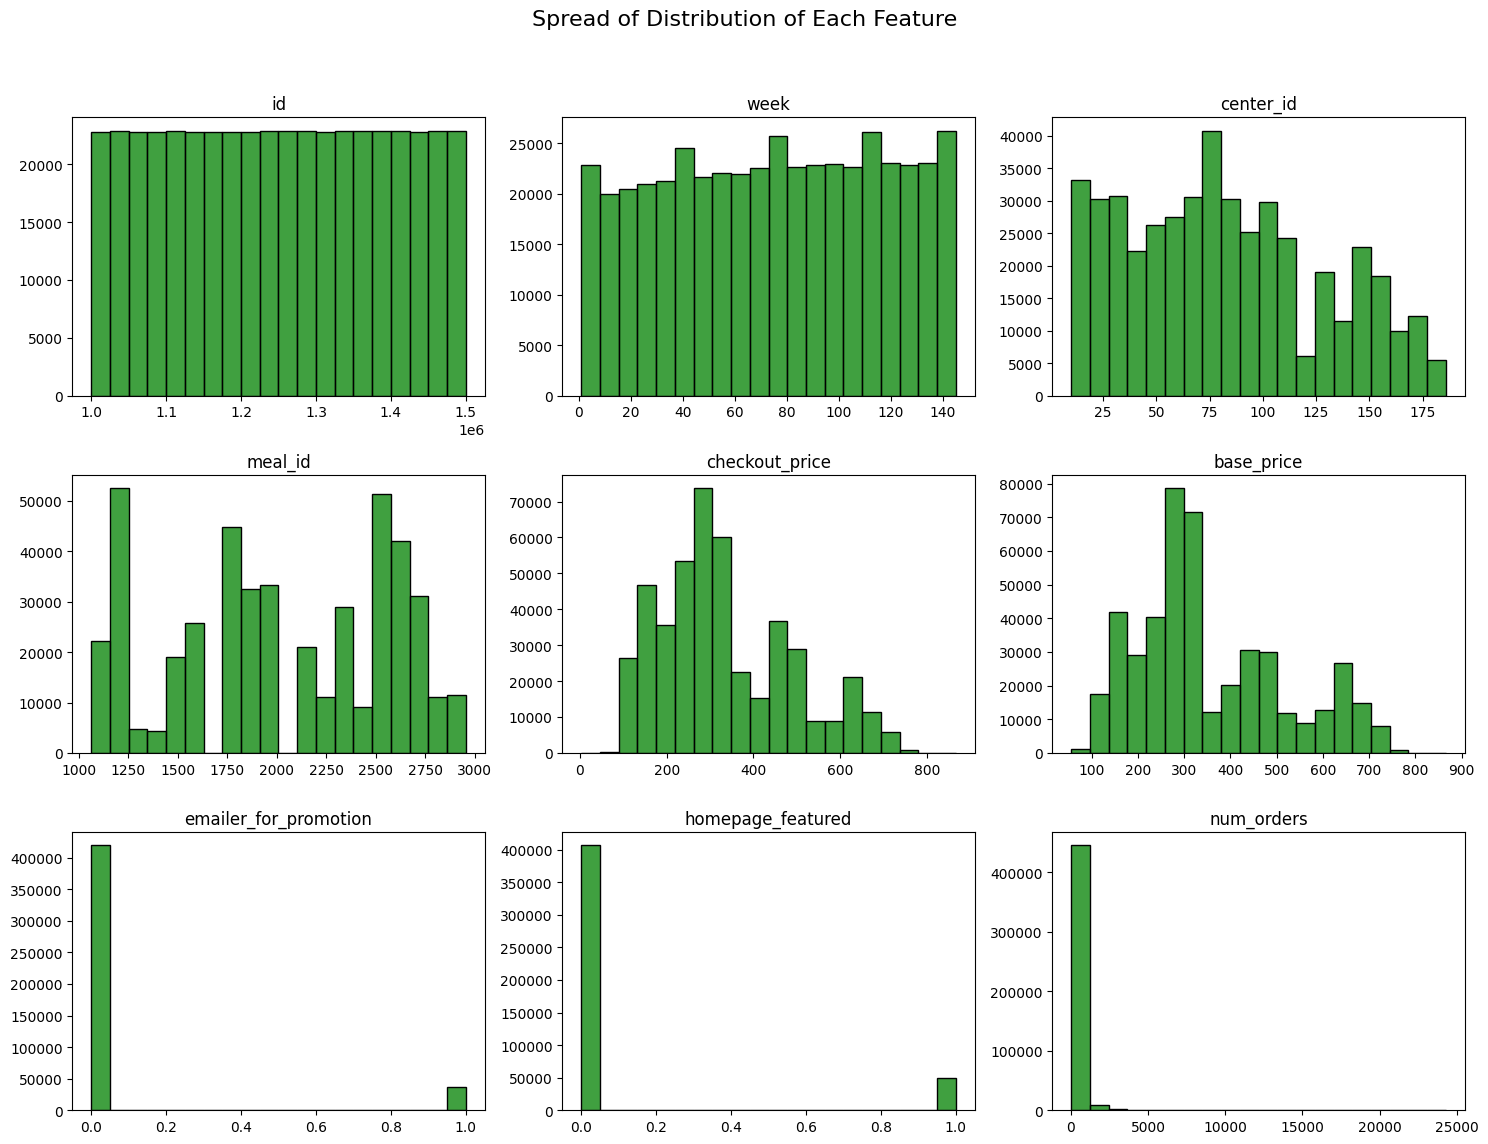

In [ ]:
# Generating plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # Adjust number of rows and columns as needed
fig.suptitle('Spread of Distribution of Each Feature', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(train.columns):
    if i < len(axes):  # Ensure we don't try to plot more columns than we have axes for
        sns.histplot(train[column], bins=20, kde=False, ax=axes[i], color='green')
        axes[i].set_title(column)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save and show plot
plt.show()

As observed for ‘‘num_orders’’ in Fig. 1,
most of the values for this feature are concentrated around
0-1000, but the spread of the distribution is greater than
20000 which implies that there might be a possibility of an outlier

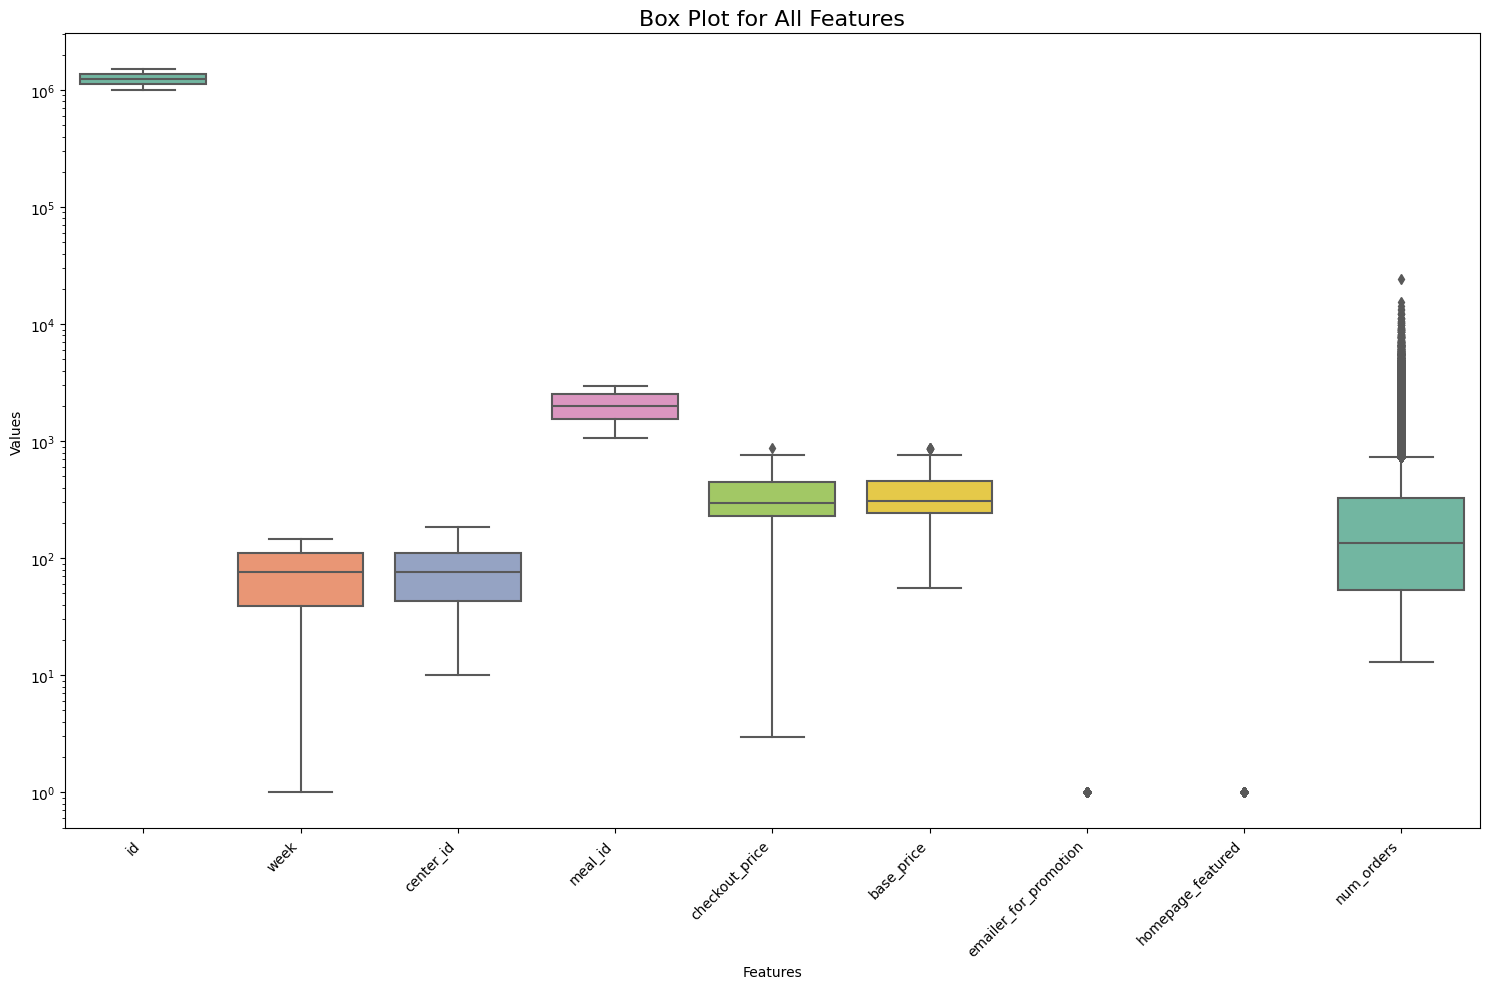

In [ ]:
# Creating a boxplot with logarithmic scale for the y-axis
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=train, palette="Set2")

# Set plot title and labels
plt.title('Box Plot for All Features', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Values')

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Improve layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save and show plot
plt.show()

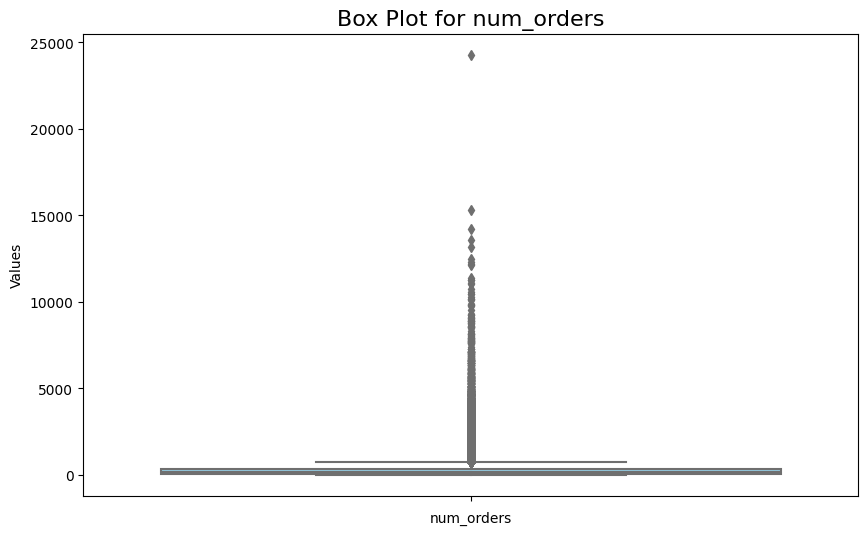

In [ ]:
# Creating a boxplot for the 'num_orders' column
plt.figure(figsize=(10, 6))
sns.boxplot(y=train['num_orders'], color='skyblue')

# Set plot title and labels
plt.title('Box Plot for num_orders', fontsize=16)
plt.xlabel('num_orders')
plt.ylabel('Values')

# Show plot
plt.show()

As seen in Fig. 2 and Fig. 3, there is only one outlier
in the number of orders that may be a result of miswriting and is therefore removed as it may hinder the further
analysis.

In [ ]:
# Count the number of rows with num_orders > 20,000
num_rows_to_delete = train[train['num_orders'] > 20000].shape[0]
print(f"Number of rows with num_orders > 20,000: {num_rows_to_delete}")

# Delete rows with num_orders > 20,000
train = train[train['num_orders'] <= 20000]

Number of rows with num_orders > 20,000: 1


In [ ]:
centres.head(1)

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7


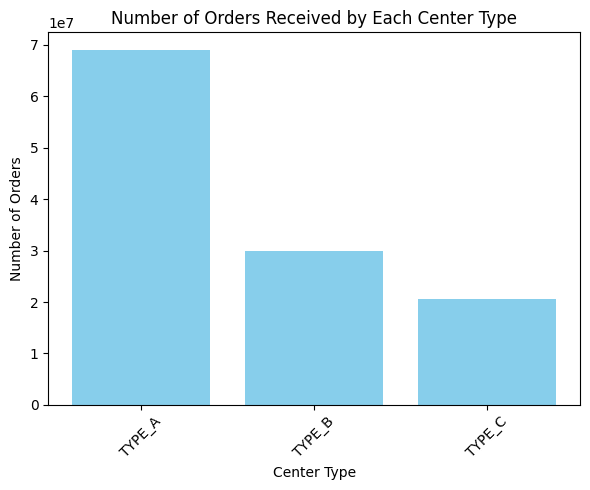

In [ ]:
# Let's merge the 'train' DataFrame with the 'centers' DataFrame to get center type information
train_with_center_type = pd.merge(train, centres, on='center_id', how='left')

# Now, let's calculate the total number of orders received by each center type
orders_by_center_type = train_with_center_type.groupby('center_type')['num_orders'].sum().reset_index()

# Plotting
plt.figure(figsize=(6, 5))
plt.bar(orders_by_center_type['center_type'], orders_by_center_type['num_orders'], color='skyblue')
plt.title('Number of Orders Received by Each Center Type')
plt.xlabel('Center Type')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

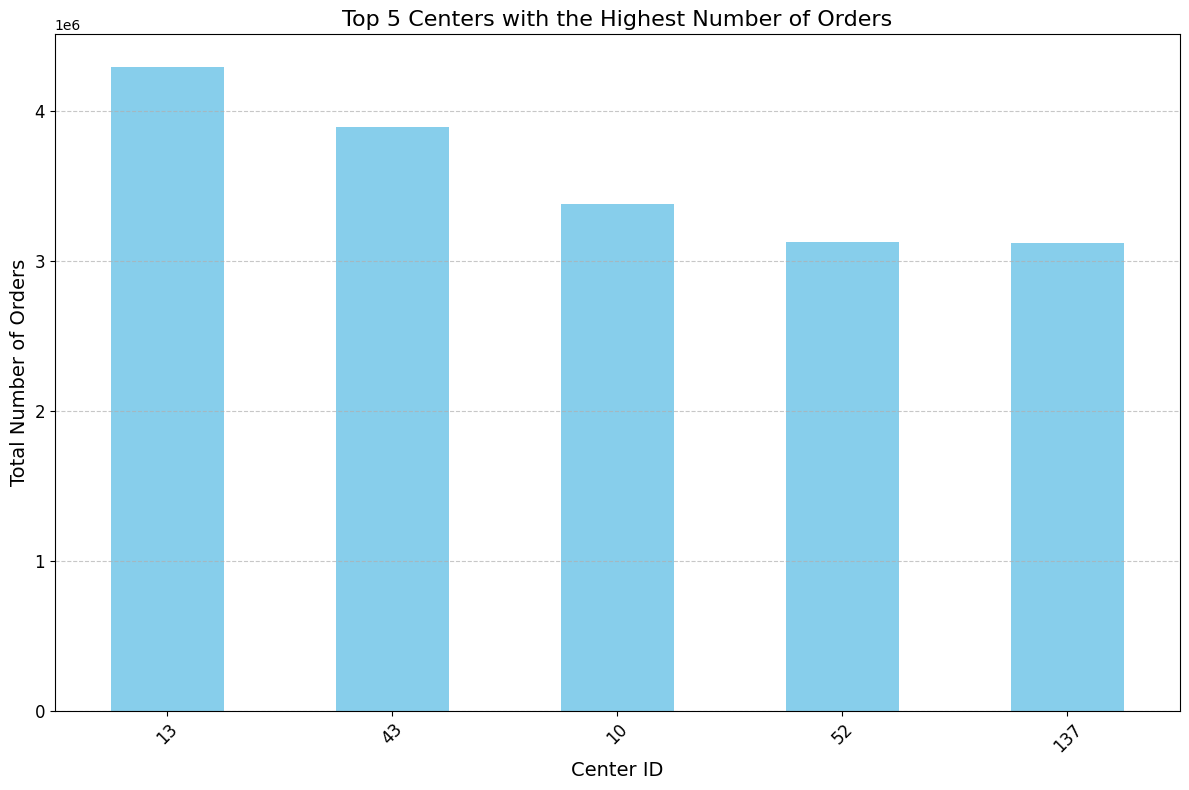

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train is your DataFrame containing the data
top_centers = train.groupby('center_id')['num_orders'].sum().nlargest(5)

# Plotting
plt.figure(figsize=(12, 8))
top_centers.plot(kind='bar', color='skyblue')
plt.title('Top 5 Centers with the Highest Number of Orders', fontsize=16)
plt.xlabel('Center ID', fontsize=14)
plt.ylabel('Total Number of Orders', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Type_A centers received the highest number of
orders, whereas Type_C centers received the least.

In [ ]:
# Assuming top_centers is the Series containing the top 5 centers with the highest number of orders
# Assuming centres is the DataFrame containing center information

# Get the top 5 center IDs
top_center_ids = top_centers.index

# Merge with the centers DataFrame to get center type
top_centers_info = centres[centres['center_id'].isin(top_center_ids)]

# Display center type of the top 5 centers
top_centers_with_type = top_centers_info.merge(top_centers.rename('num_orders'), left_on='center_id', right_index=True)
top_centers_with_type = top_centers_with_type[['center_id', 'center_type']].drop_duplicates()

print(top_centers_with_type)


    center_id center_type
1          13      TYPE_B
36         43      TYPE_A
56         10      TYPE_B
58         52      TYPE_B
62        137      TYPE_A


Type_A has the highest number of
orders, but, according to the above, it is seen that center 13 of
Type_B has the highest number of orders. The reason behind
it is that center Type_A has the most centers as shown below

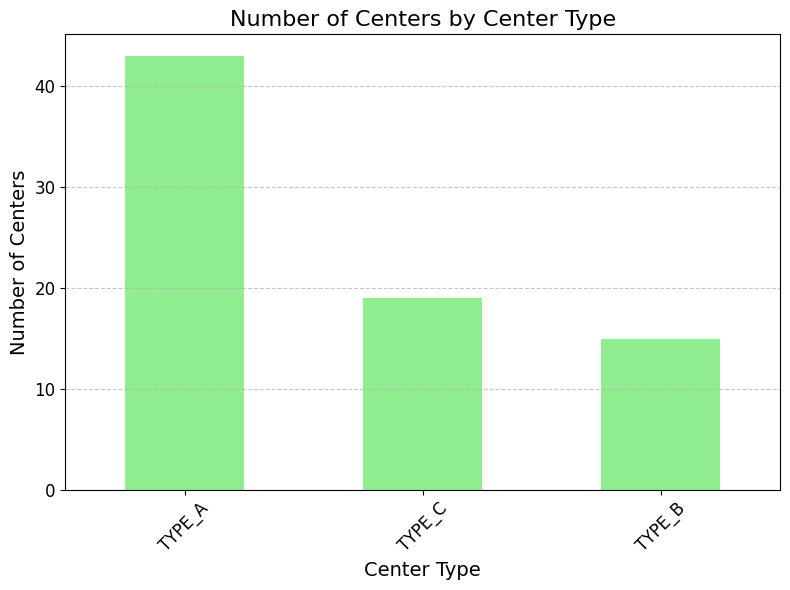

In [ ]:
# Assuming centres is the DataFrame containing center information

# Count the number of centers under each center type
center_type_counts = centres['center_type'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
center_type_counts.plot(kind='bar', color='lightgreen')
plt.title('Number of Centers by Center Type', fontsize=16)
plt.xlabel('Center Type', fontsize=14)
plt.ylabel('Number of Centers', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

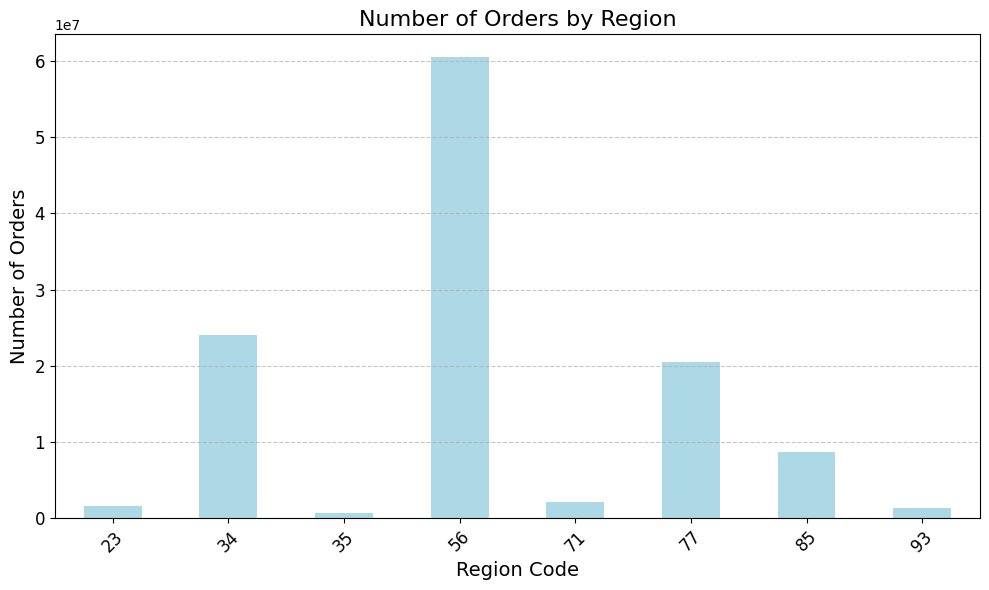

In [ ]:
# Merge the train DataFrame with the centres DataFrame
merged_data = train.merge(centres, on='center_id')

# Group by region_code and sum up the number of orders for each region
region_order_counts = merged_data.groupby('region_code')['num_orders'].sum()

# Plotting
plt.figure(figsize=(10, 6))
region_order_counts.plot(kind='bar', color='lightblue')
plt.title('Number of Orders by Region', fontsize=16)
plt.xlabel('Region Code', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 Region 56 received an astonishingly high number of
orders when compared to other regions

In [ ]:
meals.head(1)

,meal_id,category,cuisine
0,1885,Beverages,Thai


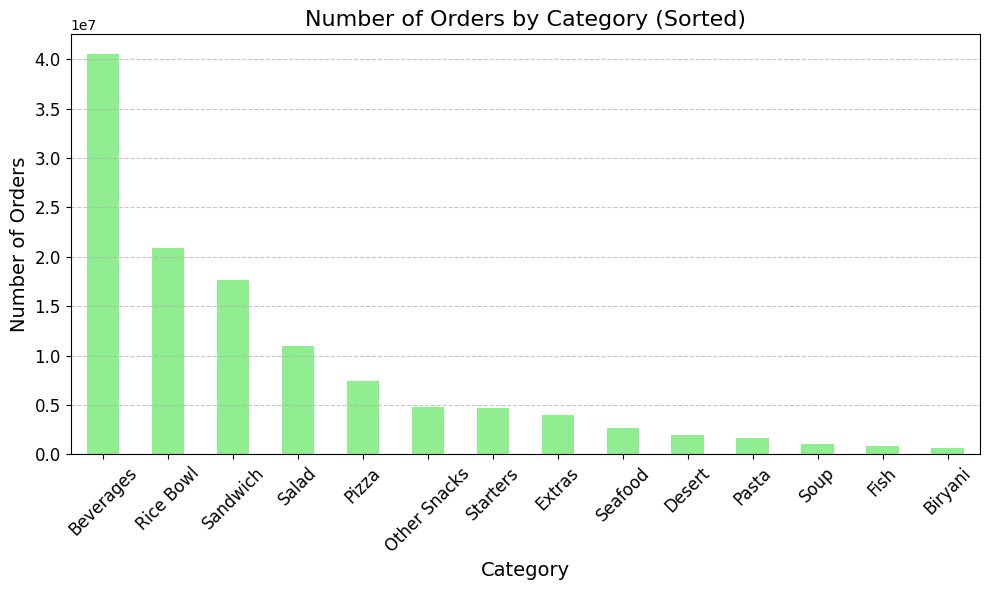

In [ ]:
# Merge the train DataFrame with the meals DataFrame on meal_id
merged_data = train.merge(meals, on='meal_id')

# Group by category and sum up the number of orders for each category
category_order_counts = merged_data.groupby('category')['num_orders'].sum()

# Sort the categories by the total number of orders in descending order
category_order_counts_sorted = category_order_counts.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
category_order_counts_sorted.plot(kind='bar', color='lightgreen')
plt.title('Number of Orders by Category (Sorted)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Beverages are the food category with the highest number
of orders, and Biryani is the food category with the least
number of orders

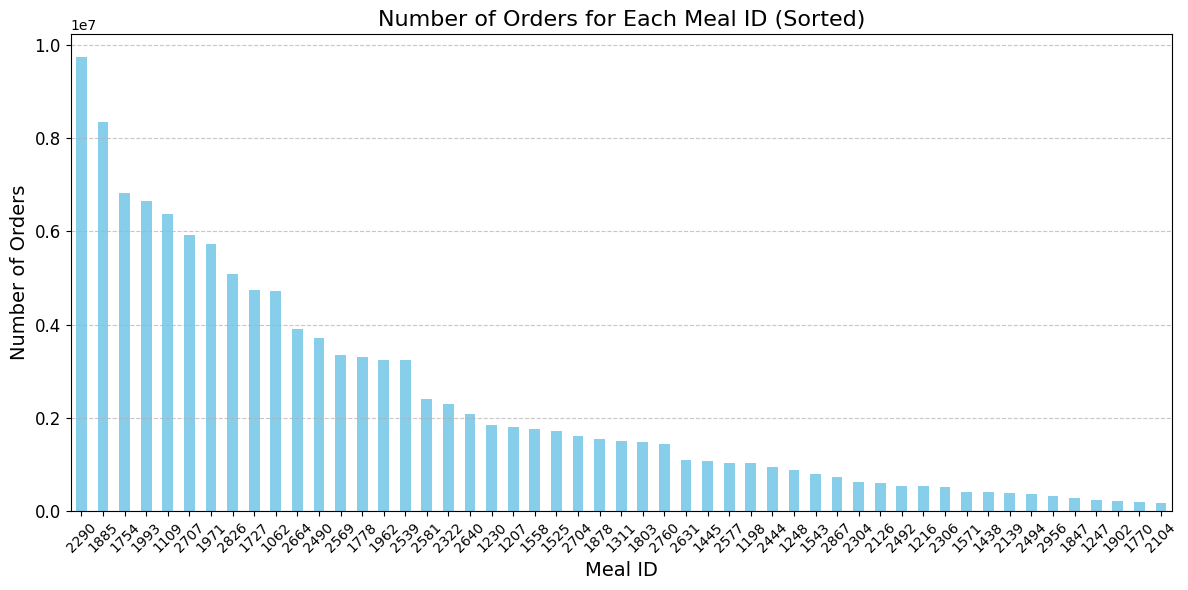

In [ ]:
# Group by meal_id and sum up the number of orders for each meal
meal_order_counts = train.groupby('meal_id')['num_orders'].sum()

# Sort the meal IDs by the total number of orders in descending order
meal_order_counts_sorted = meal_order_counts.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
meal_order_counts_sorted.plot(kind='bar', color='skyblue')
plt.title('Number of Orders for Each Meal ID (Sorted)', fontsize=16)
plt.xlabel('Meal ID', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Meal ID 2290 has received the most orders,
as shown in Fig. 9. The number of orders for various meal IDs
does not differ significantly in many cases

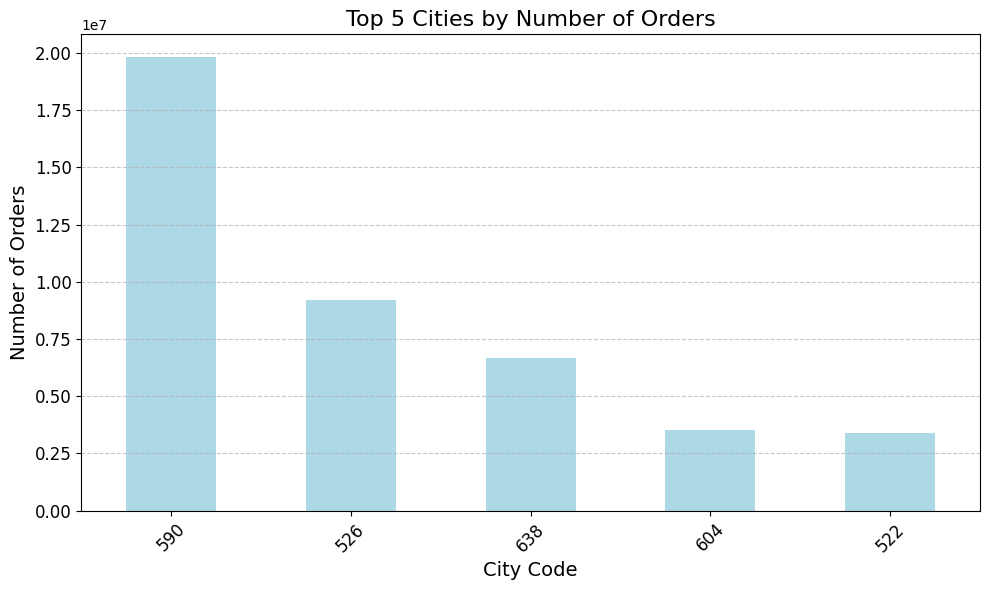

In [ ]:
# Merge the train DataFrame with the centres DataFrame on center_id
merged_data = train.merge(centres, on='center_id')

# Group by city_code and sum up the number of orders for each city
city_order_counts = merged_data.groupby('city_code')['num_orders'].sum()

# Select the top 5 cities with the highest number of orders
top_5_cities = city_order_counts.nlargest(5)

# Plotting
plt.figure(figsize=(10, 6))
top_5_cities.plot(kind='bar', color='lightblue')
plt.title('Top 5 Cities by Number of Orders', fontsize=16)
plt.xlabel('City Code', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

City - 590 has the most orders with 18.5M, which is nearly
10M more than the city with the second-highest number of
orders, City 526, with 8.6M

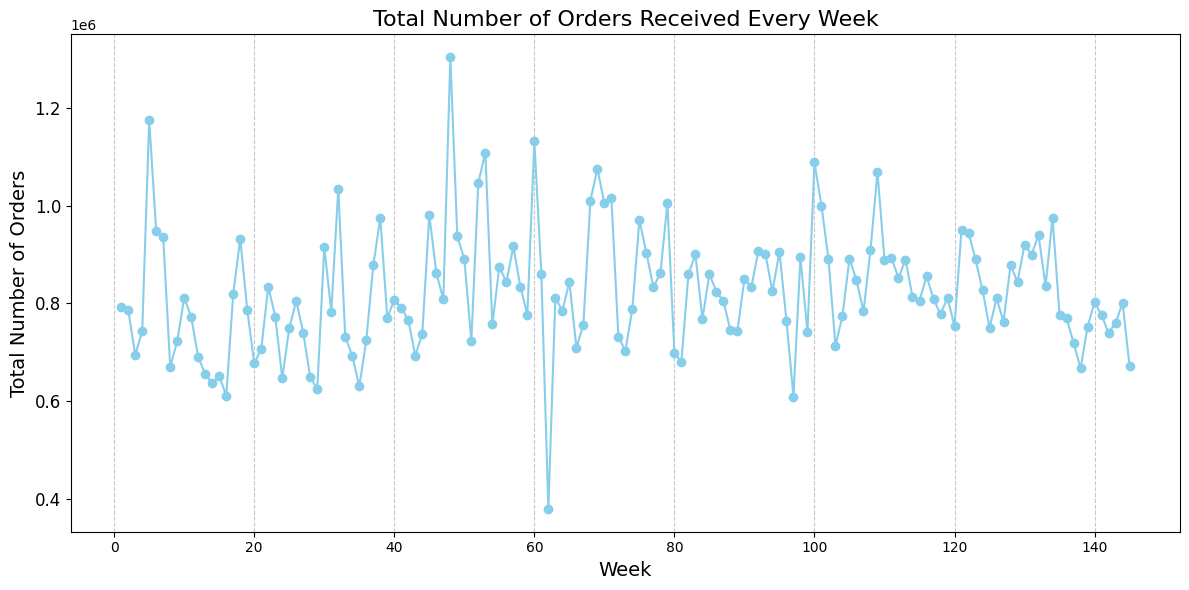

In [ ]:
# Group by week and sum up the number of orders for each week
weekly_order_counts = train.groupby('week')['num_orders'].sum()

# Plotting
plt.figure(figsize=(12, 6))
weekly_order_counts.plot(kind='line', marker='o', color='skyblue')
plt.title('Total Number of Orders Received Every Week', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Total Number of Orders', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 the highest number of orders
were received in week 48 and the lowest number of orders
in week 62

## Multivariate Analysis

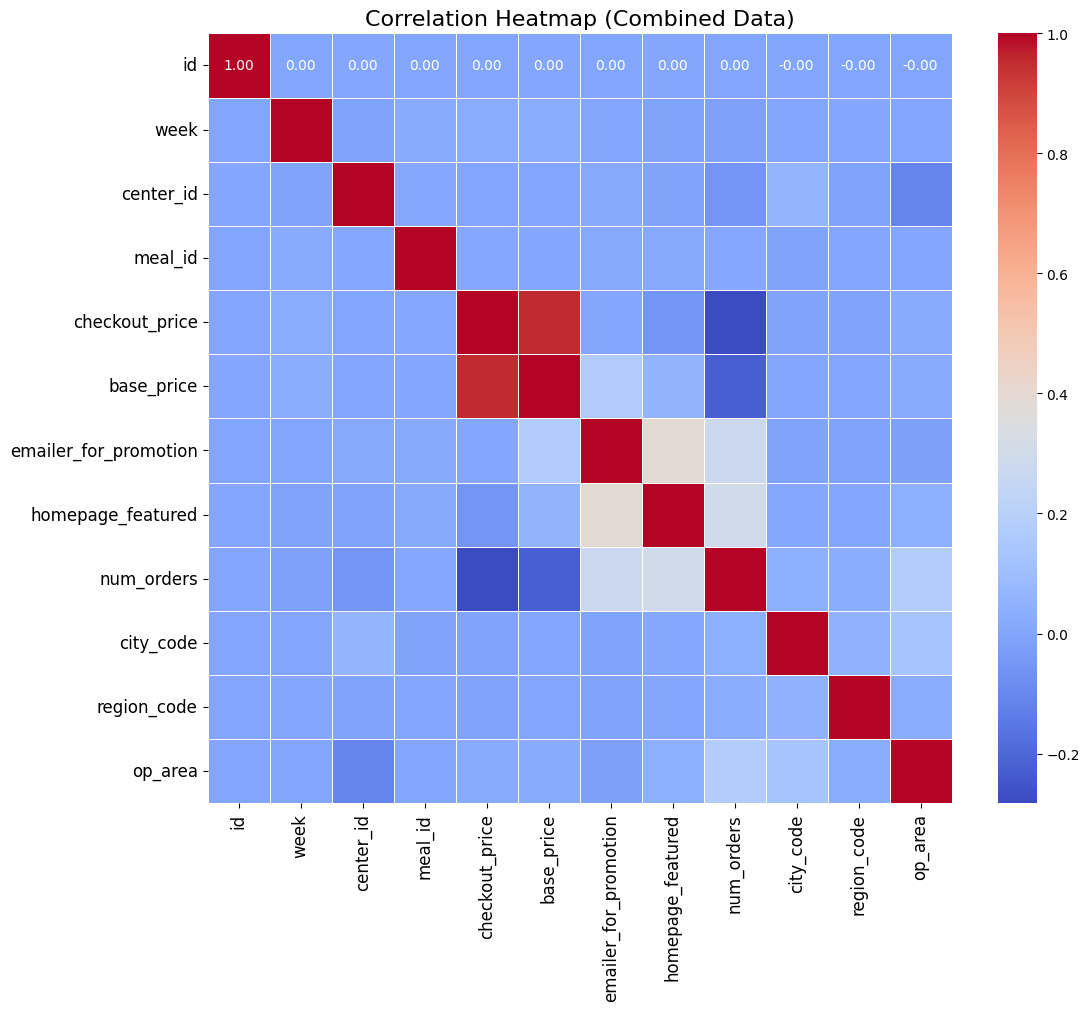

In [ ]:
# Select numeric columns from train, centres, and meals DataFrames
train_numeric = train.select_dtypes(include=['float64', 'int64'])
centres_numeric = centres.select_dtypes(include=['float64', 'int64'])
meals_numeric = meals.select_dtypes(include=['float64', 'int64'])

# Merge train, centres, and meals DataFrames
merged_data = pd.merge(train_numeric, centres_numeric, on='center_id')
merged_data = pd.merge(merged_data, meals_numeric, on='meal_id')

# Calculate the correlation matrix
corr_matrix = merged_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Combined Data)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

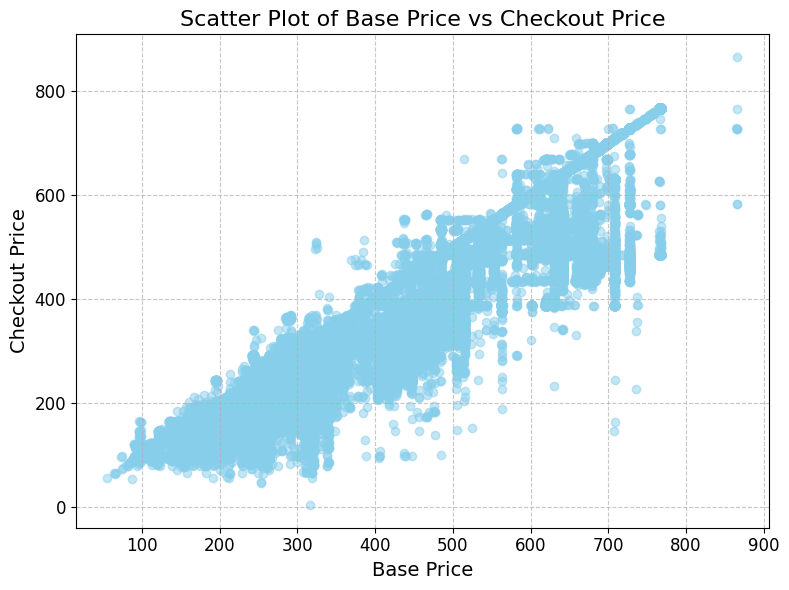

In [ ]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(train['base_price'], train['checkout_price'], color='skyblue', alpha=0.5)
plt.title('Scatter Plot of Base Price vs Checkout Price', fontsize=16)
plt.xlabel('Base Price', fontsize=14)
plt.ylabel('Checkout Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Figs above prove that base_price and checkout_price
have a high correlation, so checkout_price must be removed.

## Feature Engineering

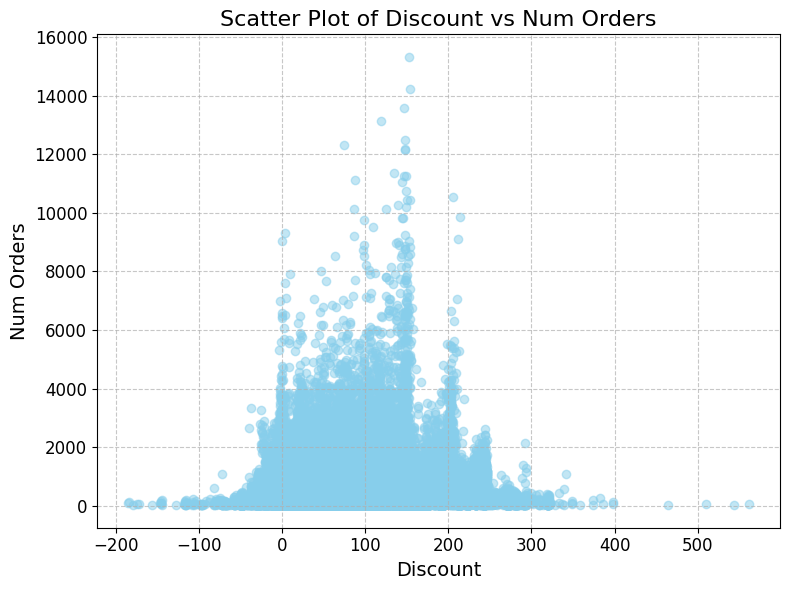

In [ ]:
# Create the 'discount' feature
train['discount'] = train['base_price'] - train['checkout_price']

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(train['discount'], train['num_orders'], color='skyblue', alpha=0.5)
plt.title('Scatter Plot of Discount vs Num Orders', fontsize=16)
plt.xlabel('Discount', fontsize=14)
plt.ylabel('Num Orders', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 a new feature is
created: a discount, which is the difference between the base
price and the checkout price. We attempted to determine
whether or not there is a relationship between the discount
and the number of orders. Surprisingly, there is no strong link
between them

In [ ]:
# Drop the 'checkout_price' column permanently
train.drop('checkout_price', axis=1, inplace=True)

1. **Lag Characteristics**: Imagine you're trying to predict something (like sales) for next week. One way to do this is by looking at what happened in previous weeks. Lag characteristics are like looking back in time to see what happened in the past, which can help us predict what might happen in the future.

2. **Exponentially Weighted Moving Average (EWMA)**: When we use lag characteristics, we often give equal importance to data from all the previous weeks. However, in real life, we usually care more about recent data because it's more relevant to what's happening now. EWMA is a way to consider recent data more than older data when making predictions.

EWMA(w) = α ∗ x(w) + (1 − α) ∗ EWMA(w − 1)

3. **How EWMA Works**: EWMA calculates a kind of average where recent data gets more weight than older data. The formula for EWMA looks complicated, but it's not too hard to understand. Basically, it says that the EWMA for this week is a combination of the actual data for this week and the EWMA from last week. The parameter α decides how much weight we give to the actual data for this week. Setting α to 0.5 means we give equal importance to the actual data for this week and the EWMA from last week.

In simpler terms, EWMA helps us make better predictions by focusing more on recent data, which is often more important for understanding what might happen next.

In this case, data from the previous 10 weeks is used to forecast demand for the next 10 weeks.

In [ ]:
# Create lag feature for num_orders_lag_10
train['num_orders_lag_10'] = train['num_orders'].shift(10)

# Drop rows with NaN values resulting from shifting
train.dropna(inplace=True)

In [ ]:
# Define the window size for EWMA (number of weeks)
window = 10  

# Calculate the EWMA using the pandas rolling function with alpha = 0.5
train['ewma_num_orders'] = train['num_orders'].ewm(alpha=0.5, min_periods=1).mean()

# Display the DataFrame with the EWMA column added
print(train[['week', 'num_orders', 'ewma_num_orders']])

        week  num_orders  ewma_num_orders
10         1         823       823.000000
11         1         972       922.333333
12         1         162       487.857143
13         1         420       451.666667
14         1         756       608.741935
...      ...         ...              ...
456543   145          68        69.149037
456544   145          42        55.574518
456545   145         501       278.287259
456546   145         729       503.643630
456547   145         162       332.821815

[456537 rows x 3 columns]


In [ ]:
merged_data = pd.merge(train, centres, on='center_id')
merged_data = pd.merge(merged_data, meals, on='meal_id')

In [ ]:
merged_data.head()

,id,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,num_orders,discount,num_orders_lag_10,ewma_num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1469367,1,55,1230,390.00,0,1,823,66.99,177.0,823.000000,647,56,TYPE_C,2.0,Beverages,Continental
1,1029333,1,55,2322,388.00,0,1,972,65.93,270.0,922.333333,647,56,TYPE_C,2.0,Beverages,Continental
2,1446016,1,55,2290,310.43,0,0,162,-1.00,189.0,487.857143,647,56,TYPE_C,2.0,Rice Bowl,Indian
3,1244647,1,55,1727,446.23,0,0,420,1.00,54.0,451.666667,647,56,TYPE_C,2.0,Rice Bowl,Indian
4,1378227,1,55,1109,297.79,1,0,756,32.95,40.0,608.741935,647,56,TYPE_C,2.0,Rice Bowl,Indian


Other features calculated include the rank of a meal based
on its base price, meal count features in relation to a meal’s
category, cuisine, center, city, and region, as well as the
highest, lowest, and average prices of the meal in a city and
a region.

In [ ]:
# Rank of a meal based on its base price
merged_data['meal_base_price_rank'] = merged_data['base_price'].rank(method='dense')

# Meal count features
meal_count_features = ['category', 'cuisine', 'center_id', 'city_code', 'region_code']
for feature in meal_count_features:
    merged_data[f'meal_count_{feature}'] = merged_data.groupby(feature)['meal_id'].transform('count')

# Highest, lowest, and average prices of the meal in a city and a region
price_features = ['city_code', 'region_code']
for feature in price_features:
    merged_data[f'{feature}_highest_price'] = merged_data.groupby(feature)['base_price'].transform('max')
    merged_data[f'{feature}_lowest_price'] = merged_data.groupby(feature)['base_price'].transform('min')
    merged_data[f'{feature}_avg_price'] = merged_data.groupby(feature)['base_price'].transform('mean')

# Set to display max columns
pd.set_option('display.max_columns', None)
# Display the DataFrame with the new features added
train = merged_data
train.head()

,id,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,num_orders,discount,num_orders_lag_10,ewma_num_orders,city_code,region_code,center_type,op_area,category,cuisine,meal_base_price_rank,meal_count_category,meal_count_cuisine,meal_count_center_id,meal_count_city_code,meal_count_region_code,city_code_highest_price,city_code_lowest_price,city_code_avg_price,region_code_highest_price,region_code_lowest_price,region_code_avg_price
0,1469367,1,55,1230,390.00,0,1,823,66.99,177.0,823.000000,647,56,TYPE_C,2.0,Beverages,Continental,944.0,127880,102794,5136,11823,191217,728.53,113.49,351.511869,767.33,55.35,352.523502
1,1029333,1,55,2322,388.00,0,1,972,65.93,270.0,922.333333,647,56,TYPE_C,2.0,Beverages,Continental,936.0,127880,102794,5136,11823,191217,728.53,113.49,351.511869,767.33,55.35,352.523502
2,1446016,1,55,2290,310.43,0,0,162,-1.00,189.0,487.857143,647,56,TYPE_C,2.0,Rice Bowl,Indian,697.0,33407,112608,5136,11823,191217,728.53,113.49,351.511869,767.33,55.35,352.523502
3,1244647,1,55,1727,446.23,0,0,420,1.00,54.0,451.666667,647,56,TYPE_C,2.0,Rice Bowl,Indian,1117.0,33407,112608,5136,11823,191217,728.53,113.49,351.511869,767.33,55.35,352.523502
4,1378227,1,55,1109,297.79,1,0,756,32.95,40.0,608.741935,647,56,TYPE_C,2.0,Rice Bowl,Indian,657.0,33407,112608,5136,11823,191217,728.53,113.49,351.511869,767.33,55.35,352.523502


compute a few more features from the existing ones in train,
which are mentioned as follows:
1) base_price_max: maximum base price for a particular
meal, irrespective of the week, center, city, or region.
2) base_price_mean: the average base price for a particular meal, irrespective of the week, center, city or region.
3) base_price_min: the minimum base price for a particular meal, irrespective of the week, center, city or region.
4) center_cat_count: a count of orders belonging to a
particular category in a particular center.
5) center_cat_price_rank: rank of the price of a particular
category of meals in a particular center.
6) center_cat_week_count: a count of orders belonging to
a particular category in a particular center in a week.
7) center_cui_count: a count of orders belonging to a
particular cuisine in a particular center.
8) center_price_rank: rank of the price of a particular meal
in a particular center.
9) center_week_count: a count of orders in a particular
center in the given week.
10) center_week_price_rank: rank of price of a particular
meal in a particular center in a particular week.
11) city_meal_week_count: a total count of a certain meal
sold in a city in a particular week.
12) meal_count: a count of a certain meal sold in all the
weeks across all centers and regions.
13) meal_city_price_rank: rank of price of a particular
meal in a particular city.
14) meal_price_max: maximum checkout price of the meal
irrespective of the week,center,city or region.
15) meal_price_mean: average checkout price of the meal
irrespective of the week,center,city or region.
16) meal_price_min: minimum checkout price of the meal
irrespective of the week,center,city or
region.
17) meal_price_rank: rank of price of a particular meal.
18) meal_region_price_rank: rank of price of a particular
meal in a particular region.
19) meal_week_count: a total count of a certain meal sold
in the given week.
20) meal_week_price_rank: rank of price of a particular
meal in a particular week.
21) region_meal_count: a region’s total sales of a particular
meal.
22) region_meal_week_count: the total number of a
specific meal sold in a region during a specific
week.
23) type_meal_week_count: the total amount of a specific
meal sold in a center over the course of a particular
week

In [ ]:
# Compute base_price_max, base_price_mean, and base_price_min
train['base_price_max'] = train['base_price'].groupby(train['meal_id']).transform('max')
train['base_price_mean'] = train['base_price'].groupby(train['meal_id']).transform('mean')
train['base_price_min'] = train['base_price'].groupby(train['meal_id']).transform('min')

# Compute center_cat_count
train['center_cat_count'] = train.groupby(['center_id', 'category'])['num_orders'].transform('count')

# Compute center_cat_price_rank
train['center_cat_price_rank'] = train.groupby(['center_id', 'category'])['base_price'].transform('rank')

# Compute center_cat_week_count
train['center_cat_week_count'] = train.groupby(['center_id', 'category', 'week'])['num_orders'].transform('sum')

# Compute center_cui_count
train['center_cui_count'] = train.groupby(['center_id', 'cuisine'])['num_orders'].transform('count')

# Compute center_price_rank
train['center_price_rank'] = train.groupby(['center_id'])['base_price'].transform('rank')

# Compute center_week_count
train['center_week_count'] = train.groupby(['center_id', 'week'])['num_orders'].transform('sum')

# Compute center_week_price_rank
train['center_week_price_rank'] = train.groupby(['center_id', 'week'])['base_price'].transform('rank')

# Compute city_meal_week_count
train['city_meal_week_count'] = train.groupby(['city_code', 'meal_id', 'week'])['num_orders'].transform('sum')

# Compute meal_count
train['meal_count'] = train.groupby(['meal_id'])['num_orders'].transform('sum')

# Compute meal_city_price_rank
train['meal_city_price_rank'] = train.groupby(['meal_id', 'city_code'])['base_price'].transform('rank')

# Compute meal_price_max, meal_price_mean, and meal_price_min
train['meal_price_max'] = train['base_price'].groupby(train['meal_id']).transform('max')
train['meal_price_mean'] = train['base_price'].groupby(train['meal_id']).transform('mean')
train['meal_price_min'] = train['base_price'].groupby(train['meal_id']).transform('min')

# Compute meal_price_rank
train['meal_price_rank'] = train.groupby(['meal_id'])['base_price'].transform('rank')

# Compute meal_region_price_rank
train['meal_region_price_rank'] = train.groupby(['meal_id', 'region_code'])['base_price'].transform('rank')

# Compute meal_week_count
train['meal_week_count'] = train.groupby(['meal_id', 'week'])['num_orders'].transform('sum')

# Compute meal_week_price_rank
train['meal_week_price_rank'] = train.groupby(['meal_id', 'week'])['base_price'].transform('rank')

# Compute region_meal_count
train['region_meal_count'] = train.groupby(['region_code', 'meal_id'])['num_orders'].transform('sum')

# Compute region_meal_week_count
train['region_meal_week_count'] = train.groupby(['region_code', 'meal_id', 'week'])['num_orders'].transform('sum')

# Compute type_meal_week_count
train['type_meal_week_count'] = train.groupby(['center_id', 'week', 'meal_id'])['num_orders'].transform('sum')

# Display the DataFrame with the new features added
train.head()

,id,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,num_orders,discount,num_orders_lag_10,ewma_num_orders,city_code,region_code,center_type,op_area,category,cuisine,meal_base_price_rank,meal_count_category,meal_count_cuisine,meal_count_center_id,meal_count_city_code,meal_count_region_code,city_code_highest_price,city_code_lowest_price,city_code_avg_price,region_code_highest_price,region_code_lowest_price,region_code_avg_price,base_price_max,base_price_mean,base_price_min,center_cat_count,center_cat_price_rank,center_cat_week_count,center_cui_count,center_price_rank,center_week_count,center_week_price_rank,city_meal_week_count,meal_count,meal_city_price_rank,meal_price_max,meal_price_mean,meal_price_min,meal_price_rank,meal_region_price_rank,meal_week_count,meal_week_price_rank,region_meal_count,region_meal_week_count,type_meal_week_count
0,1469367,1,55,1230,390.00,0,1,823,66.99,177.0,823.000000,647,56,TYPE_C,2.0,Beverages,Continental,944.0,127880,102794,5136,11823,191217,728.53,113.49,351.511869,767.33,55.35,352.523502,533.53,368.473102,266.81,1636,1391.5,1795,1239,3541.5,5895,13.0,1389,1843969,135.0,533.53,368.473102,266.81,8133.5,1996.5,24199,69.0,671575,12558,823
1,1029333,1,55,2322,388.00,0,1,972,65.93,270.0,922.333333,647,56,TYPE_C,2.0,Beverages,Continental,936.0,127880,102794,5136,11823,191217,728.53,113.49,351.511869,767.33,55.35,352.523502,515.13,369.166474,273.54,1636,1342.5,1795,1239,3381.0,5895,12.0,1539,2298221,125.0,515.13,369.166474,273.54,7832.0,1777.0,29371,63.5,1044102,16295,972
2,1446016,1,55,2290,310.43,0,0,162,-1.00,189.0,487.857143,647,56,TYPE_C,2.0,Rice Bowl,Indian,697.0,33407,112608,5136,11823,191217,728.53,113.49,351.511869,767.33,55.35,352.523502,330.83,284.706274,221.16,434,192.5,1338,1171,2547.5,5895,8.0,811,9746004,230.0,330.83,284.706274,221.16,9873.0,3727.5,45326,62.0,4310788,17906,162
3,1244647,1,55,1727,446.23,0,0,420,1.00,54.0,451.666667,647,56,TYPE_C,2.0,Rice Bowl,Indian,1117.0,33407,112608,5136,11823,191217,728.53,113.49,351.511869,767.33,55.35,352.523502,505.43,430.771363,296.82,434,344.5,1338,1171,3734.5,5895,14.5,1137,4735987,116.5,505.43,430.771363,296.82,7997.0,2004.0,28606,71.0,2456808,15475,420
4,1378227,1,55,1109,297.79,1,0,756,32.95,40.0,608.741935,647,56,TYPE_C,2.0,Rice Bowl,Indian,657.0,33407,112608,5136,11823,191217,728.53,113.49,351.511869,767.33,55.35,352.523502,347.32,302.683526,191.09,434,85.5,1338,1171,2289.5,5895,6.0,2065,6367773,105.0,347.32,302.683526,191.09,3629.5,1596.5,63984,54.0,3332710,41364,756


# Feature Processing

## Impute Missing Values

first, lets have a quick overview before deciding how to handle missing values

In [ ]:
train.isnull().sum()

id                           0
week                         0
center_id                    0
meal_id                      0
base_price                   0
emailer_for_promotion        0
homepage_featured            0
num_orders                   0
discount                     0
num_orders_lag_10            0
ewma_num_orders              0
city_code                    0
region_code                  0
center_type                  0
op_area                      0
category                     0
cuisine                      0
meal_base_price_rank         0
meal_count_category          0
meal_count_cuisine           0
meal_count_center_id         0
meal_count_city_code         0
meal_count_region_code       0
city_code_highest_price      0
city_code_lowest_price       0
city_code_avg_price          0
region_code_highest_price    0
region_code_lowest_price     0
region_code_avg_price        0
base_price_max               0
base_price_mean              0
base_price_min               0
center_c

The values for each feature are not on the same scale, and
most of the numerical features in the dataset are heavily
right-skewed. Skewness can be decreased by applying the
quantile or power transformation. Both were used and compared

In [ ]:
# Quantile Transformation
quantile_transformer = QuantileTransformer(output_distribution='normal')
train['num_orders_quantile'] = quantile_transformer.fit_transform(train[['num_orders']].values)

# Power Transformation
power_transformer = PowerTransformer()
train['num_orders_power'] = power_transformer.fit_transform(train[['num_orders']].values)

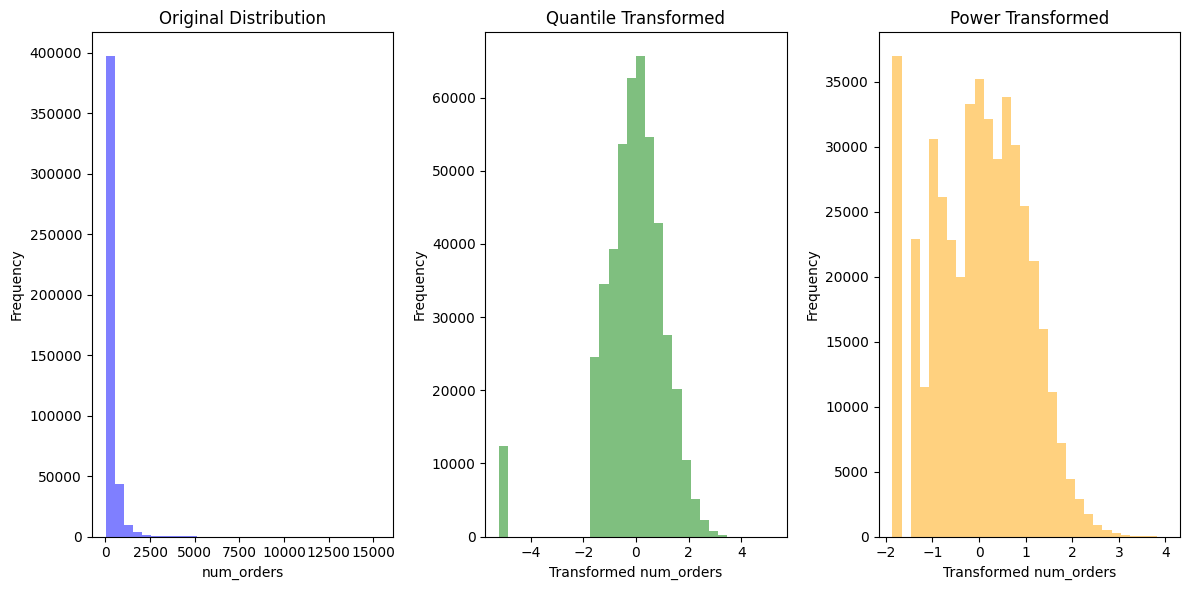

In [ ]:
# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Original Distribution
plt.subplot(1, 3, 1)
plt.hist(train['num_orders'], bins=30, color='blue', alpha=0.5)
plt.title('Original Distribution')
plt.xlabel('num_orders')
plt.ylabel('Frequency')

# Quantile Transformed Distribution
plt.subplot(1, 3, 2)
plt.hist(train['num_orders_quantile'], bins=30, color='green', alpha=0.5)
plt.title('Quantile Transformed')
plt.xlabel('Transformed num_orders')
plt.ylabel('Frequency')

# Power Transformed Distribution
plt.subplot(1, 3, 3)
plt.hist(train['num_orders_power'], bins=30, color='orange', alpha=0.5)
plt.title('Power Transformed')
plt.xlabel('Transformed num_orders')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

 it is
evident that the quantile transformation reduced skewness
more than the power transformation in our case.

The purpose of these transformations is to make the distribution of the data more symmetric and closer to a normal distribution.

since the data already resembles a normal distribution after transformation, standardization (scaling to mean 0 and standard deviation 1) is a better option than normalization.

In [ ]:
# Drop the 'num_orders_power' column permanently
train.drop(['id', 'num_orders_power'], axis=1, inplace=True)

## Features Encoding & scaling

In [ ]:
train.head(2)

,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,num_orders,discount,num_orders_lag_10,ewma_num_orders,city_code,region_code,center_type,op_area,category,cuisine,meal_base_price_rank,meal_count_category,meal_count_cuisine,meal_count_center_id,meal_count_city_code,meal_count_region_code,city_code_highest_price,city_code_lowest_price,city_code_avg_price,region_code_highest_price,region_code_lowest_price,region_code_avg_price,base_price_max,base_price_mean,base_price_min,center_cat_count,center_cat_price_rank,center_cat_week_count,center_cui_count,center_price_rank,center_week_count,center_week_price_rank,city_meal_week_count,meal_count,meal_city_price_rank,meal_price_max,meal_price_mean,meal_price_min,meal_price_rank,meal_region_price_rank,meal_week_count,meal_week_price_rank,region_meal_count,region_meal_week_count,type_meal_week_count,num_orders_quantile
0,1,55,1230,390.0,0,1,823,66.99,177.0,823.000000,647,56,TYPE_C,2.0,Beverages,Continental,944.0,127880,102794,5136,11823,191217,728.53,113.49,351.511869,767.33,55.35,352.523502,533.53,368.473102,266.81,1636,1391.5,1795,1239,3541.5,5895,13.0,1389,1843969,135.0,533.53,368.473102,266.81,8133.5,1996.5,24199,69.0,671575,12558,823,1.579296
1,1,55,2322,388.0,0,1,972,65.93,270.0,922.333333,647,56,TYPE_C,2.0,Beverages,Continental,936.0,127880,102794,5136,11823,191217,728.53,113.49,351.511869,767.33,55.35,352.523502,515.13,369.166474,273.54,1636,1342.5,1795,1239,3381.0,5895,12.0,1539,2298221,125.0,515.13,369.166474,273.54,7832.0,1777.0,29371,63.5,1044102,16295,972,1.738163


In [ ]:
train['meal_city_price_rank'].nunique()

2286

In [ ]:
train_week = train[['week']]

In [ ]:
categoric_columns = ['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code', 'center_type', 'op_area', 'category', 'cuisine']
columns = list(train.columns) 
numeric_columns = [i for i in columns if i not in categoric_columns]

In [ ]:
numeric_columns.remove('num_orders')
print(numeric_columns)

['week', 'base_price', 'discount', 'num_orders_lag_10', 'ewma_num_orders', 'meal_base_price_rank', 'meal_count_category', 'meal_count_cuisine', 'meal_count_center_id', 'meal_count_city_code', 'meal_count_region_code', 'city_code_highest_price', 'city_code_lowest_price', 'city_code_avg_price', 'region_code_highest_price', 'region_code_lowest_price', 'region_code_avg_price', 'base_price_max', 'base_price_mean', 'base_price_min', 'center_cat_count', 'center_cat_price_rank', 'center_cat_week_count', 'center_cui_count', 'center_price_rank', 'center_week_count', 'center_week_price_rank', 'city_meal_week_count', 'meal_count', 'meal_city_price_rank', 'meal_price_max', 'meal_price_mean', 'meal_price_min', 'meal_price_rank', 'meal_region_price_rank', 'meal_week_count', 'meal_week_price_rank', 'region_meal_count', 'region_meal_week_count', 'type_meal_week_count', 'num_orders_quantile']


In [ ]:
# encoder = BinaryEncoder(drop_invariant=False, return_df=True,)
# encoder.fit(train[categoric_columns])

# Initialize LabelEncoder
encoder = LabelEncoder()

In [ ]:
scaler = StandardScaler()
scaler.set_output(transform="pandas")
scaler.fit(train[numeric_columns])

StandardScaler()

In [ ]:
scaled_num = scaler.transform(train[numeric_columns])
# encoded_cat = encoder.transform(train[categoric_columns])
encoded_cat = train[categoric_columns].apply(encoder.fit_transform)
train = pd.concat([scaled_num, encoded_cat, train.num_orders], axis=1)

In [ ]:
train.head()

,week,base_price,discount,num_orders_lag_10,ewma_num_orders,meal_base_price_rank,meal_count_category,meal_count_cuisine,meal_count_center_id,meal_count_city_code,meal_count_region_code,city_code_highest_price,city_code_lowest_price,city_code_avg_price,region_code_highest_price,region_code_lowest_price,region_code_avg_price,base_price_max,base_price_mean,base_price_min,center_cat_count,center_cat_price_rank,center_cat_week_count,center_cui_count,center_price_rank,center_week_count,center_week_price_rank,city_meal_week_count,meal_count,meal_city_price_rank,meal_price_max,meal_price_mean,meal_price_min,meal_price_rank,meal_region_price_rank,meal_week_count,meal_week_price_rank,region_meal_count,region_meal_week_count,type_meal_week_count,num_orders_quantile,id,center_id,meal_id,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,num_orders
0,-1.776582,0.223006,0.929411,-0.215106,2.107124,0.250504,1.591806,-1.604459,-1.261945,-0.322822,1.028807,-0.880504,1.372819,-0.495235,-0.463854,-0.777403,-0.713068,0.506787,0.090869,0.199365,1.538213,2.562307,0.12953,-1.049456,0.296966,-0.920964,-0.673675,0.320181,-0.361517,-0.223981,0.506787,0.090869,0.199365,1.098281,0.542851,0.217687,1.653924,-0.157379,0.771989,1.423141,1.319877,428527,23,5,0,1,30,3,2,2,0,0,823
1,-1.776582,0.210561,0.907553,0.020740,2.480102,0.233849,1.591806,-1.604459,-1.261945,-0.322822,1.028807,-0.880504,1.372819,-0.495235,-0.463854,-0.777403,-0.713068,0.405407,0.095270,0.251772,1.538213,2.438978,0.12953,-1.049456,0.207046,-0.920964,-0.754027,0.403049,-0.173519,-0.264667,0.405407,0.095270,0.251772,0.997810,0.337000,0.439378,1.390003,0.232972,1.198116,1.801003,1.471359,26761,23,33,0,1,30,3,2,2,0,0,972
2,-1.776582,-0.272091,-0.472567,-0.184675,0.848723,-0.263725,-0.494464,-0.273719,-1.261945,-0.322822,1.028807,-0.880504,1.372819,-0.495235,-0.463854,-0.777403,-0.713068,-0.610053,-0.440915,-0.156111,-0.539078,-0.455475,-0.10607,-1.289707,-0.259925,-0.920964,-1.075436,0.000866,2.908841,0.162537,-0.610053,-0.440915,-0.156111,1.677953,2.166213,1.123268,1.318024,3.655953,1.381818,-0.253143,0.145136,407140,23,30,0,0,30,3,2,2,8,1,162
3,-1.776582,0.572878,-0.431327,-0.527032,0.712835,0.610673,-0.494464,-0.273719,-1.261945,-0.322822,1.028807,-0.880504,1.372819,-0.495235,-0.463854,-0.777403,-0.713068,0.351961,0.486362,0.433053,-0.539078,-0.072904,-0.10607,-1.289707,0.405095,-0.920964,-0.553147,0.180964,0.835381,-0.299250,0.351961,0.486362,0.433053,1.052794,0.549885,0.406587,1.749895,1.713269,1.104613,0.401141,0.788297,223239,23,15,0,0,30,3,2,2,8,1,420
4,-1.776582,-0.350740,0.227494,-0.562536,1.302624,-0.347001,-0.494464,-0.273719,-1.261945,-0.322822,1.028807,-0.880504,1.372819,-0.495235,-0.463854,-0.777403,-0.713068,-0.519196,-0.326789,-0.390266,-0.539078,-0.724785,-0.10607,-1.289707,-0.404470,-0.920964,-1.236140,0.693637,1.510717,-0.346039,-0.519196,-0.326789,-0.390266,-0.402632,0.167724,1.923019,0.934138,2.631078,4.056716,1.253231,1.249228,345246,23,1,1,0,30,3,2,2,8,1,756


In [ ]:
train['week_unscaled'] = train_week
# Split the dataset into training (weeks 1-135) and evaluation (weeks 136-145) sets
trainn = train[train['week_unscaled'] <= 135]
evall = train[train['week_unscaled'] > 135]

# Display the shapes of the training and evaluation sets
print("Training set shape:", trainn.shape)
print("Evaluation set shape:", evall.shape)

trainn.drop('week_unscaled', axis=1, inplace=True)
evall.drop('week_unscaled', axis=1, inplace=True)

NameError: name 'merged3' is not defined

In [ ]:
# Split data into parts
X_train = trainn.drop(['num_orders'], axis = 1)
X_test = evall.drop(['num_orders'], axis = 1)
y_train = trainn['num_orders']
y_test = evall['num_orders']

# Machine Learning Modeling 

# Traditional Machine Learning Models

### DecisionTreeRegressor

In [ ]:

tree = DecisionTreeRegressor()
model_tree = tree.fit(X_train, y_train)

# Make prediction on X_test
tree_pred = model_tree.predict(X_test)

<BarContainer object of 26 artists>

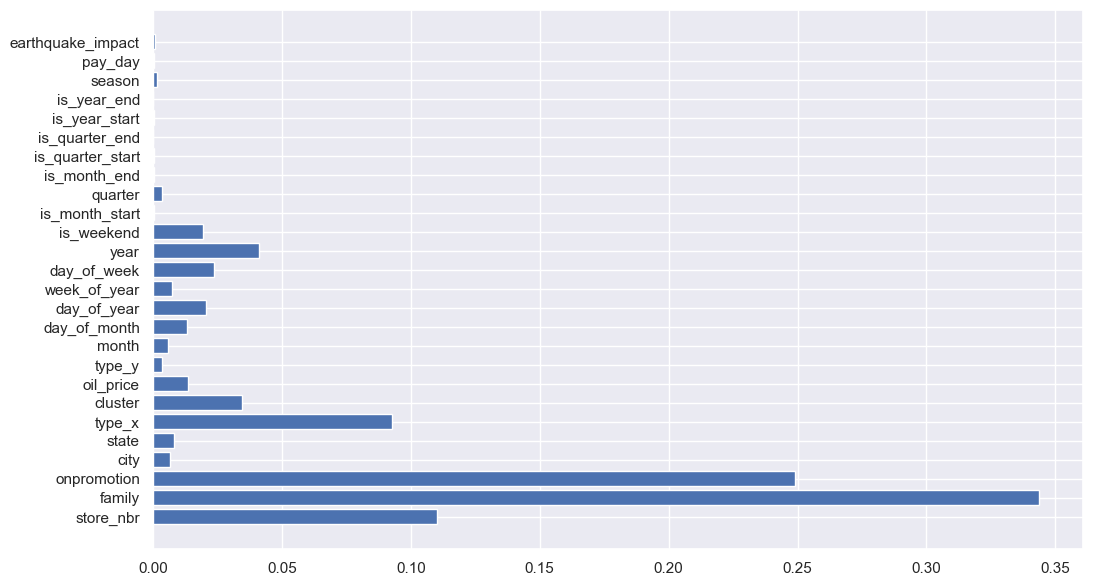

In [ ]:
# feature importance for decision tree
plt.figure(figsize=(12,7))
plt.barh(x.columns, model_tree.feature_importances_)

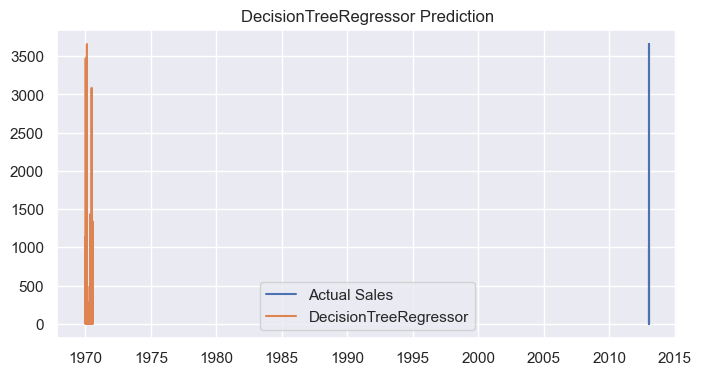

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(tree_pred, label='DecisionTreeRegressor')
plt.legend(loc='best')
plt.title('DecisionTreeRegressor Prediction')
plt.show()

In [ ]:
mse = mean_squared_error(y_test, tree_pred )
rmse = np.sqrt(mean_squared_error(y_test, tree_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, tree_pred)).round(2)
msle = mean_squared_log_error(y_test, tree_pred).round(2)


results = pd.DataFrame([['DecisionTree', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear,230030.436642,479.61,NaN,NaN
1,DecisionTree,5384.248293,73.38,0.07,0.27


### KNN

In [ ]:

neigh = KNeighborsRegressor(n_neighbors=1)
# fit model no training data
neigh.fit(X_train, y_train)

# make predictions for test data
neigh_pred = neigh.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, neigh_pred )
msle = mean_squared_log_error(y_test, neigh_pred)
rmse = np.sqrt(mean_squared_error(y_test, neigh_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, neigh_pred)).round(5)

# model_results = pd.DataFrame([['lightGBM', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
model_results = pd.DataFrame([['KNN', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear,230030.436642,479.61,NaN,NaN
1,KNN,2628.070195,51.26,0.293239,0.54152


## BackTest

In [ ]:
backtests = {
    1: ('2017-07-01', '2017-07-15'),
    2: ('2017-07-15', '2017-07-30'),
    3: ('2017-08-01', '2017-08-15')
}

In [ ]:
# Backtests with Decision Tree
scores = {}

for idx, period in enumerate(backtests):
    
    _train = trainn.reset_index()[trainn.reset_index()['date'] < backtests[period][0]]
    _test = trainn.reset_index()[(trainn.reset_index()['date'] >= backtests[period][0]) & (trainn.reset_index()['date'] <= backtests[period][1])]
    
    Xtrain, ytrain = _train.set_index(['date']).drop(columns=['sales']).values, _train.sales.values
    Xtest, ytest = _test.set_index(['date']).drop(columns=['sales']).values, _test.sales.values
    
    lgbm_model = DecisionTreeRegressor().fit(Xtrain, ytrain)
    
    ypred = lgbm_model.predict(Xtest)
    
    scores[period] = np.sqrt(mean_squared_log_error(ytest, ypred))

print(scores)

## trying our validation set on DecisionTeee Model (overfitting or underfitting)

In [ ]:
# Split data into parts
x = evall.drop(['sales'], axis = 1)
y = evall['sales']

In [ ]:
# Make prediction on X_test
tree_pred = neigh.predict(x)

In [ ]:
mse = mean_squared_error(y, tree_pred )
rmse = np.sqrt(mean_squared_error(y, tree_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y, tree_pred)).round(6)
msle = mean_squared_log_error(y, tree_pred).round(2)


results = pd.DataFrame([['DecisionTree', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

,Model,MSE,MSLE,RMSE,RMSLE
0,DecisionTree,526781.23984,3.43,725.8,1.851066


## Preparing our test data

In [ ]:
test

,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0
...,...,...,...,...
28507,2017-08-31,9,POULTRY,1
28508,2017-08-31,9,PREPARED FOODS,0
28509,2017-08-31,9,PRODUCE,1
28510,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


for our test data, we merge just like for our train data

In [ ]:
mer_test = test.merge(
    stores, 
    how='left', 
    on=['store_nbr'])
#merging merged with oil data
merged2_test=mer_test.merge(
    oil,
    how='left', 
    on=['date'])
#merging merged2 with holidays
merged3_test=merged2_test.merge(holidays,
    how='left', 
    on=['date'])

(16, 2)


,store_nbr,onpromotion
date,,
2017-08-16,27.5,17.137486
2017-08-17,27.5,4.211560
2017-08-18,27.5,7.731201


In [ ]:
merged3.isnull().sum()

### predicting sales in our test

In [ ]:
# test_pred = armodel.predict(merged3_test_resampled)
test_pred = armodel.predict(
    start=len(x),
    end=len(x)+ len(test_date) -1,
    dynamic=False
)
test_pred[np.isnan(test_pred)] = 0
test_pred

2017-08-16    418.225351
2017-08-17    414.127187
2017-08-18    446.862944
2017-08-19    503.986936
2017-08-20    510.704314
2017-08-21    456.135285
2017-08-22    418.585445
2017-08-23    414.614947
2017-08-24    414.650586
2017-08-25    440.043247
2017-08-26    483.082974
2017-08-27    486.541744
2017-08-28    444.431947
2017-08-29    414.629915
2017-08-30    411.255707
2017-08-31    413.387713
Freq: D, dtype: float64

In [ ]:
test_sales = pd.DataFrame(test_pred, columns=['sales'])
test_sales.head(30)

,sales
2017-08-16,418.225351
2017-08-17,414.127187
2017-08-18,446.862944
2017-08-19,503.986936
2017-08-20,510.704314
2017-08-21,456.135285
2017-08-22,418.585445
2017-08-23,414.614947
2017-08-24,414.650586
2017-08-25,440.043247


In [ ]:
# Save sample submission
# test_sales[[ 'sales']].to_csv('submission.csv', index=False)

In [ ]:
# import pickle

# with open('encoder.pkl', 'wb') as f:
#     pickle.dump(encoder, f)

# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

# with open("model.pkl", "wb") as f:
    # pickle.dump(model_tree, f)